
## Trabalho Prático III
### Aprendizado Profundo para Processamento de Linguagem Natural (2025/2)
# Transcrição de caracteres chineses como uma tarefa de classificação em NLP
**Aluno:** Marcelo Augusto Salomão Ganem

**Matrícula:** 2020054684

Modelamos a tarefa de **transcrição de pinyin** (a sintaxe romanizada para escrita do chinês) **para hanzi** (ideogramas correspondentes) como _single-label classification_, visando atribuir a cada pinyin o rótulo que representa o hanzi correspondente. Esse mapeamento não é trivial: para cada pinyin, existem múltiplos hanzi válidos, a serem desambiguados com base no contexto da frase.

![usage](https://github.com/masganem/nlp-tp3/blob/main/usage.gif?raw=true "usage")

Apesar da utilidade prática atingida por modelos puramente baseados em regras, soluções baseadas em _Hidden Markov Models_ e modelos estatísticos de _n-grams_ constituíram um salto expressivo na acurácia e conveniência de uso para tais modelos. Atualmente, soluções baseadas em aprendizado profundo, incluindo modelos _sequence-to-sequence_ com mecanismos de atenção, representam o estado da arte nessa tarefa.

Temos por objetivo superar a _baseline_ trivial da escolha do hanzi mais frequente para cada pinyin (e.g, melhor chute) por meio de aprendizado profundo, treinando redes neurais em uma _Bidirectional Gated Recurrent Unit_. A flexibilidade da solução é inferior comparada a paradigmas _sequence-to-sequence_, mas a eficiência por dados de treino é maior; o tamanho do modelo também é compatível com os recursos disponíveis para os experimentos necessários.

## Preparações
De início, carregamos bibliotecas para requisitar e realizar a leitura do dataset (`urllib`, `csv`), instanciar e realizar operações com tensores (`torch`) e renderizar gráficos (`matplotlib`), dentre outras funções e classes utilitárias.

Para instalar as bibliotecas externas utilizadas, basta executar
```bash
pip install torch tqdm matplotlib
```
em um terminal de comando.

Este notebook foi implementado e testado com Python v`3.13.9`.

In [3]:
import math
import matplotlib.pyplot as plt
import re
import urllib.request
import csv
import random
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, Counter

DEVICE = torch.device("cpu")
SPECIALS = ["<pad>", "<unk>"]
DATASET_URL = "https://huggingface.co/datasets/Duyu/Pinyin-Hanzi/resolve/main/pinyin2hanzi.csv"
_PINYIN_TOKEN_RE = re.compile(r"^[A-Za-z]+[0-9]$")


Requisitamos o dataset da web, lendo as entradas do arquivo `.csv`.


In [ ]:
def fetch_dataset():
    content = None
    with urllib.request.urlopen(DATASET_URL) as response:
        content = response.read().decode("utf-8")
        reader = csv.reader(content.splitlines())
        return [row for row in reader if row]

raw_data = fetch_dataset()
print(raw_data[:10])


### Análise primária: comprimento das entradas 
A vasta maior parte das sentenças disponíveis no dataset é muito mais curta do que as poucas sentenças mais longas. Projetamos o comprimento das entradas (por número de _hanzi_) em escala logarítmica para identificar um ponto de corte, de maneira a minimizar a perda de dados de treino mas também viabilizar a operação com batches, bem como limitar a necessidade de _padding_ (quanto maior a maior entrada, mais _padding_ é necessário para as demais entradas).


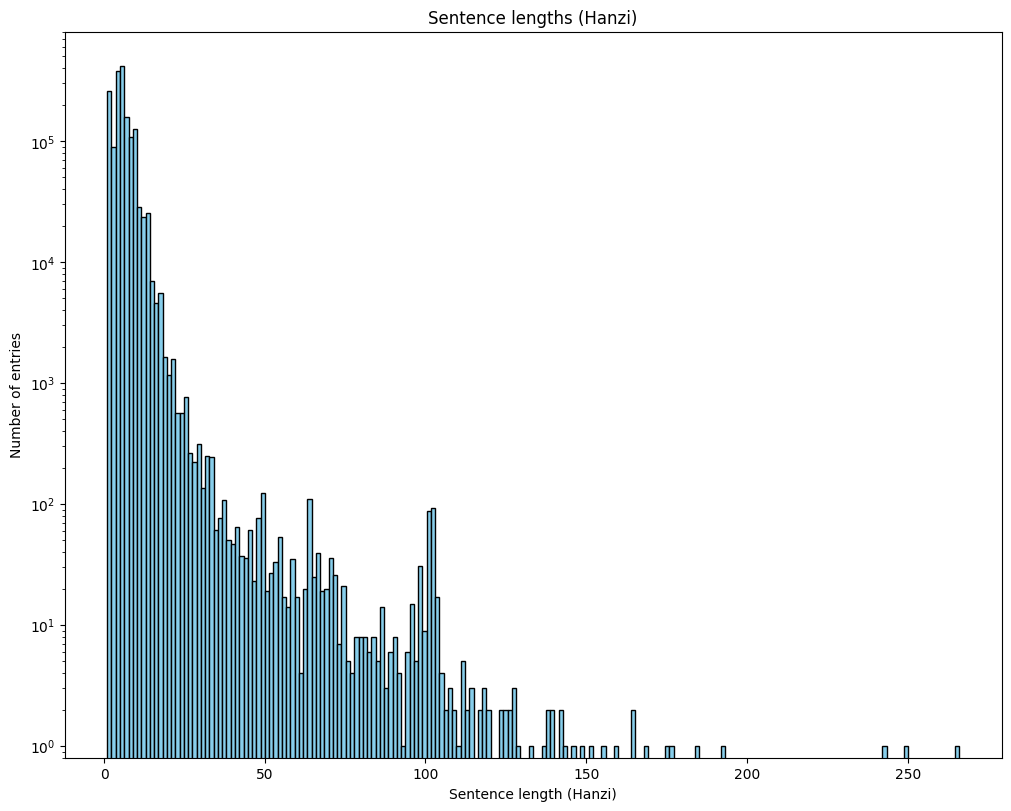

In [2]:
def _build_hist(ax, lengths, title, color):
    if not lengths:
        ax.text(0.5, 0.5, "No entries", ha="center", va="center")
        ax.set_title(title)
        ax.set_ylabel("Number of entries")
        return

    bins = max(1, min(max(lengths), 200))
    ax.hist(
        lengths,
        bins=bins,
        edgecolor="black",
        color=color,
    )
    ax.set_title(title)
    ax.set_ylabel("Number of entries")
    ax.set_xlabel("Sentence length (Hanzi)")

raw_lengths = [len(item[0]) for item in raw_data]

fig, (ax_raw) = plt.subplots(
    1, 1, figsize=(10, 8), constrained_layout=True
)

_build_hist(ax_raw, raw_lengths, "Sentence lengths (Hanzi)", "skyblue")
ax_raw.set_yscale("log")
ax_raw.set_ylim(bottom=0.8)
plt.show()

Cortamos, portanto, o centésimo percentil das sentenças, ordenadas por comprimento. Preservamos, dessa maneira, a maior parte dos dados, ainda garantindo conveniência durante o treino.

In [16]:
def _truncate_to_percentile(data, percentile=0.99):
    if not data:
        return data
    lengths = sorted(len(item[0]) for item in data)
    cutoff_index = max(0, min(len(lengths) - 1, math.ceil(percentile * len(lengths)) - 1))
    cutoff_length = lengths[cutoff_index]
    return [item for item in data if len(item[0]) <= cutoff_length]

print(len(data))
data = _truncate_to_percentile(raw_data)
print(len(data))


Projetamos um novo histograma depois do recorte, dessa vez em escala linear, para visualizar a distribuição de comprimento do conjunto de dados restantes.


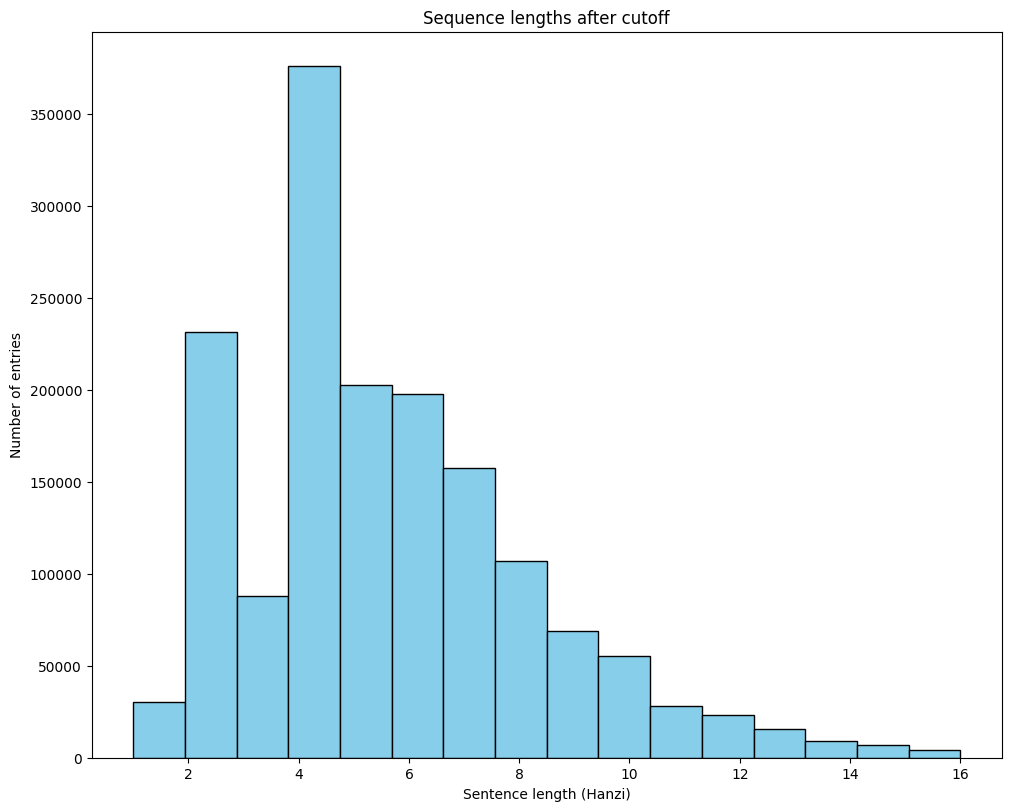

In [23]:
fig, (ax_filtered) = plt.subplots(
    1, 1, figsize=(10, 8), constrained_layout=True
)
filtered_lengths = [len(item[0]) for item in data]
_build_hist(
    ax_filtered, filtered_lengths, "Sequence lengths after cutoff", "skyblue"
)


Como estamos tratando essa tarefa de transcrição sob o paradigma de classificação, precisamos manter apenas as sentenças cujo número de hanzi é igual ao número e pinyin.


In [17]:
print(len(data))
data = [pair for pair in data if len(pair[0]) == len(pair[1].split())]
print(len(data))


Após o tratamento inicial, dividimos o conjunto de dados na proporção $4:1$ para treino e validação, respectivamente.


In [18]:
def split_dataset(pairs, train_ratio=0.8, seed=42):
    if not pairs:
        return [], []
    rng = random.Random(seed)
    shuffled = list(pairs)
    rng.shuffle(shuffled)
    split_idx = int(len(shuffled) * train_ratio)
    return shuffled[:split_idx], shuffled[split_idx:]

train_data, eval_data = split_dataset(data)


 Extraímos do dataset o conjunto de hanzi e pinyin únicos.


In [19]:
hanzi = set(
    [
        hz_char
        for hz_string in [item[0] for item in data]
        for hz_char in hz_string
    ]
)
print(len(hanzi))
print(list(hanzi)[:20])

pinyin = set(
    token
    for py_string in [item[1] for item in data]
    for token in py_string.split()
    if _PINYIN_TOKEN_RE.fullmatch(token)
)
print(len(pinyin))
print(list(pinyin)[:20])

20953
['均', '遡', '堃', '幢', '霚', '參', '蔕', '谤', '娿', '顩', '圣', '瓨', '誵', '趑', '輿', '峄', '邼', '屋', '蕟', '鄲']
1369
['biao3', 'hong3', 'xiao4', 'dao1', 'duo4', 'jue4', 'ta1', 'chuo1', 'xu4', 'mang2', 'wai1', 'gen3', 'he1', 'cuo4', 'xiang4', 'ci4', 'fou3', 'zeng4', 'sun1', 'dei1']



Construímos o vocabulário de hanzi e pinyin a partir do dataset


In [ ]:
def build_vocab(tokens):
    vocab = SPECIALS + sorted(set(tokens))
    stoi = {tok: i for i, tok in enumerate(vocab)}
    itos = list(vocab)
    return stoi, itos


Estendemos as classes `Dataset` e `DataLoader` da biblioteca `torch` para facilitar o carregamento de pares `(hanzi[], pinyin[])` em batches.
Para isso, construímos um mapa de pinyin para hanzi. Isso se deve à relação $1\rightarrow N$ entre os conjuntos: para cada pinyin, existe um conjunto limitado e definido de hanzi válidos.


In [17]:
def build_pinyin_hanzi_map(data_pairs, pinyin_stoi, hanzi_stoi):
    # Build string-level mapping
    pinyin_to_hanzi = defaultdict(set)
    for hanzi_str, pinyin_str in data_pairs:
        pinyin_tokens = pinyin_str.split()
        hanzi_chars = list(hanzi_str)
        if len(pinyin_tokens) != len(hanzi_chars):
            continue
        for py, hz in zip(pinyin_tokens, hanzi_chars):
            pinyin_to_hanzi[py].add(hz)

    # Convert to index-level mapping
    pinyin_hanzi_map = {}
    for py_token, py_id in pinyin_stoi.items():
        if py_token in SPECIALS:
            # Special tokens map to themselves or pad
            if py_token == "<pad>":
                pinyin_hanzi_map[py_id] = [hanzi_stoi["<pad>"]]
            else:
                pinyin_hanzi_map[py_id] = [hanzi_stoi["<unk>"]]
        else:
            valid_hanzi = pinyin_to_hanzi.get(py_token, set())
            hanzi_ids = [hanzi_stoi[hz] for hz in valid_hanzi if hz in hanzi_stoi]
            pinyin_hanzi_map[py_id] = sorted(hanzi_ids) if hanzi_ids else [hanzi_stoi["<unk>"]]

    return pinyin_hanzi_map

hanzi_tokens = (ch for hanzi, _ in data for ch in hanzi)
pinyin_tokens = (tok for _, pinyin in data for tok in pinyin.split())

hanzi_stoi, hanzi_itos = build_vocab(hanzi_tokens)
pinyin_stoi, pinyin_itos = build_vocab(pinyin_tokens)

pinyin_hanzi_map = build_pinyin_hanzi_map(data, pinyin_stoi, hanzi_stoi)

In [15]:
class PinyinHanziDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        hanzi, pinyin = self.pairs[idx]
        src_tokens = pinyin.split()
        tgt_tokens = list(hanzi)
        unk_py = pinyin_stoi["<unk>"]
        unk_hz = hanzi_stoi["<unk>"]
        src_ids = [pinyin_stoi.get(t, unk_py) for t in src_tokens]
        tgt_ids = [hanzi_stoi.get(c, unk_hz) for c in tgt_tokens]
        # Pure per-token alignment; no extra boundary tokens.
        tgt_in = tgt_ids
        tgt_out = tgt_ids
        return {"src": src_ids, "tgt_in": tgt_in, "tgt_out": tgt_out}

def collate_batch(batch, pad_idx_src, pad_idx_tgt):
    src = [torch.tensor(b["src"], dtype=torch.long) for b in batch]
    tgt_in = [torch.tensor(b["tgt_in"], dtype=torch.long) for b in batch]
    tgt_out = [torch.tensor(b["tgt_out"], dtype=torch.long) for b in batch]
    src_pad = nn.utils.rnn.pad_sequence(src, batch_first=True, padding_value=pad_idx_src)
    tgt_in_pad = nn.utils.rnn.pad_sequence(tgt_in, batch_first=True, padding_value=pad_idx_tgt)
    tgt_out_pad = nn.utils.rnn.pad_sequence(tgt_out, batch_first=True, padding_value=pad_idx_tgt)
    return {
        "src": src_pad,
        "tgt_in": tgt_in_pad,
        "tgt_out": tgt_out_pad,
        "src_key_padding_mask": src_pad.eq(pad_idx_src),
        "tgt_key_padding_mask": tgt_in_pad.eq(pad_idx_tgt),
    }

collate = lambda batch: collate_batch(batch, pinyin_stoi["<pad>"], hanzi_stoi["<pad>"])
dataloader = DataLoader(PinyinHanziDataset(train_data), batch_size=256, shuffle=True, collate_fn=collate)
eval_loader = DataLoader(PinyinHanziDataset(eval_data), batch_size=256, shuffle=False, collate_fn=collate)


Analisamos a distribuição de frequência entre os Hanzi.


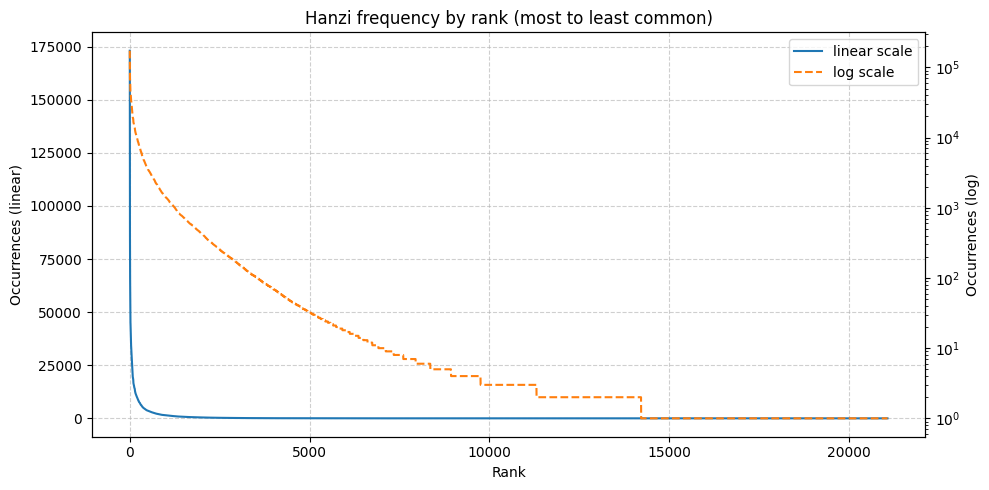

In [20]:
counts = Counter(hz for hz_string, *_ in raw_data for hz in hz_string)

ranked = counts.most_common()
ranks = range(1, len(ranked) + 1)
freq = [count for _, count in ranked]

fig, ax_linear = plt.subplots(figsize=(10, 5))
ax_log = ax_linear.twinx()

linear_line, = ax_linear.plot(ranks, freq, linewidth=1.5, color="tab:blue", label="linear scale")
log_line, = ax_log.plot(ranks, freq, linewidth=1.5, color="tab:orange", linestyle="--", label="log scale")
ax_log.set_yscale("log")

ax_linear.set_title("Hanzi frequency by rank (most to least common)")
ax_linear.set_xlabel("Rank")
ax_linear.set_ylabel("Occurrences (linear)")
ax_log.set_ylabel("Occurrences (log)")

ax_linear.grid(True, linestyle="--", alpha=0.6)
ax_linear.legend(handles=[linear_line, log_line], loc="upper right")

fig.tight_layout()
plt.show()


Analisamos os pinyin por ambiguidade (quantidade de hanzi por pinyin)


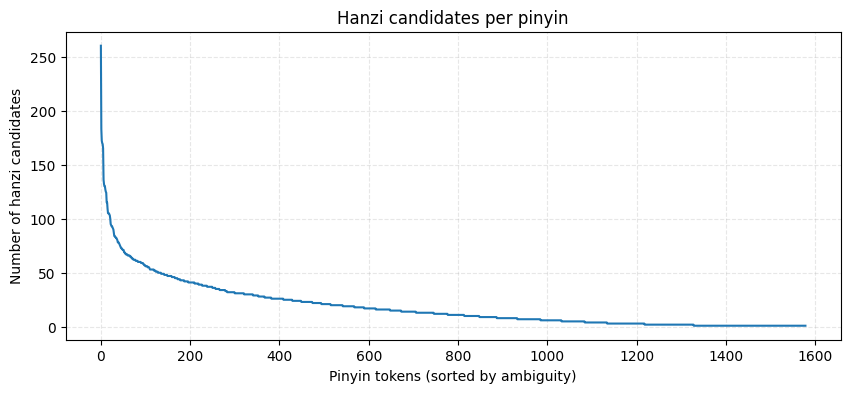

In [21]:
pinyin_to_hanzi = defaultdict(set)
for hanzi_str, pinyin_str in data:
    tokens = pinyin_str.split()
    for hz, py in zip(hanzi_str, tokens):
        pinyin_to_hanzi[py].add(hz)

hanzi_per_pinyin = sorted(
    (len(hz_set) for hz_set in pinyin_to_hanzi.values()),
    reverse=True,
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(len(hanzi_per_pinyin)), hanzi_per_pinyin, linewidth=1.5)
ax.set_xlabel("Pinyin tokens (sorted by ambiguity)")
ax.set_ylabel("Number of hanzi candidates")
ax.set_title("Hanzi candidates per pinyin")
ax.grid(True, linestyle="--", alpha=0.3)

plt.show()


## Modelo (BiGRU Classifier)
### Gated Recurrent Unit
- Simplificação da LSTM (introduzida em 2014)
- Resolve o problema de _vanishing/exploding_ gradient
- Implementa gates *reset* e *update* para controlar a propagação do estado para a memória
- Mantém um único _hidden state_ (em vez de memórias separadas, como na LSTM)
![gru](https://www.researchgate.net/publication/328462205/figure/fig4/AS:684914898923521@1540307845043/Gated-Recurrent-Unit-GRU.ppm "GRU")

### Bidirectional Gated Recurrent Unit (BiGRU)
- Duas camadas de GRU: uma lê as entradas de frente para trás, a outra de trás para frente.
- Os vetores de contexto dos últimos blocos são concatenados
![bigru](https://www.researchgate.net/publication/331459358/figure/fig2/AS:850162641534979@1579705977558/Network-architecture-of-BiGRU.png "BiGRU")

### Alterações implementadas
- Representação one-hot dos vocabulários de pinyin e hanzi
- Camada de embedding (_fully connected_)
- Concatenação de contextos vizinhos
  - O contexto a nível de bigrama ($i-1$, $i$, $i+1$) é o mais relevante na transcrição de pinyin para hanzi
- Camada de **output**:
  - Fully connected
  - Ativação da camada final via _softmax_
  - Saídas do _softmax_ são tratadas como probabilidades de escolha para cada _hanzi_ vocabulário


In [ ]:
class BiGRUTagger(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        hidden_dim,
        pad_idx,
        pinyin_hanzi_map,
        context_window = 1,  # bigram context: [i-1, i, i+1]
    ):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.encoder = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )

        self.context_window = context_window
        self.hidden_dim = hidden_dim

        # Determine max candidates across all pinyin
        self.max_candidates = max(len(candidates) for candidates in pinyin_hanzi_map.values())

        # Project from concatenated context window to max_candidates
        # context_window=2 means [h_{i-2}, h_{i-1}, h_i, h_{i+1}, h_{i+2}] → 5 * (hidden_dim * 2)
        context_size = (2 * context_window + 1) * hidden_dim * 2
        self.proj = nn.Linear(context_size, self.max_candidates)

        # Store the pinyin→hanzi mapping
        self.pinyin_hanzi_map = pinyin_hanzi_map

        # Pre-build candidate lookup tensor: [vocab_size, max_candidates]
        # candidates[pinyin_id, i] = hanzi_id for i-th valid candidate
        # Pad with -1 for pinyin with fewer than max_candidates options
        self.register_buffer("candidates", self._build_candidate_tensor(pinyin_hanzi_map))

    def _build_candidate_tensor(self, pinyin_hanzi_map): 
        vocab_size = max(pinyin_hanzi_map.keys()) + 1
        candidates = torch.full((vocab_size, self.max_candidates), -1, dtype=torch.long)

        for pinyin_id, valid_hanzi_ids in pinyin_hanzi_map.items():
            for i, hanzi_id in enumerate(valid_hanzi_ids):
                candidates[pinyin_id, i] = hanzi_id

        return candidates

    def forward(self, src):
        batch_size, seq_len = src.shape

        # Encode context
        x = self.embed(src)
        enc_out, _ = self.encoder(x)  # [batch, seq_len, hidden_dim * 2]

        # Build context windows by concatenating neighboring hidden states
        # Pad enc_out with zeros at boundaries
        pad_size = self.context_window
        enc_padded = nn.functional.pad(
            enc_out,
            (0, 0, pad_size, pad_size),  # Pad seq_len dimension
            mode='constant',
            value=0
        )  # [batch, seq_len + 2*pad_size, hidden_dim * 2]

        # Collect context windows for each position
        context_features = []
        for offset in range(-self.context_window, self.context_window + 1):
            # Shift by offset and extract the relevant slice
            start_idx = pad_size + offset
            end_idx = start_idx + seq_len
            context_features.append(enc_padded[:, start_idx:end_idx, :])

        # Concatenate all context positions: [batch, seq_len, context_size]
        context = torch.cat(context_features, dim=-1)

        # Project to candidate scores
        candidate_logits = self.proj(context)  # [batch, seq_len, max_candidates]

        # Look up which hanzi IDs these candidates correspond to
        candidate_ids = self.candidates[src]  # [batch, seq_len, max_candidates]

        # Mask out padding candidates (where candidate_id == -1)
        mask = candidate_ids == -1
        candidate_logits = candidate_logits.masked_fill(mask, float("-inf"))

        return candidate_logits, candidate_ids

### _Baseline_ 
Implementamos também uma estratégia _baseline_ que seleciona o hanzi mais frequente para qualquer pinyin. 


In [64]:
freq_counts = defaultdict(Counter)
for hanzi_str, pinyin_str in train_data:
    for hz, py in zip(hanzi_str, pinyin_str.split()):
        freq_counts[py][hz] += 1
most_freq = {py: counter.most_common(1)[0][0] for py, counter in freq_counts.items() if counter}


Avaliamos a acurácia do método _baseline_ no conjunto de validação.


In [65]:
total_tokens = 0
correct_tokens = 0
total_bigrams = 0
correct_bigrams = 0

for hanzi_str, pinyin_str in train_data:
    py_tokens = pinyin_str.split()
    preds = []
    for py in py_tokens:
        pred = most_freq.get(py)
        preds.append(pred)
    total_tokens += len(py_tokens)

    for idx, (gt, pred) in enumerate(zip(hanzi_str, preds)):
        if pred is None:
            continue
        if pred == gt:
            correct_tokens += 1

    total_bigrams += max(len(preds) - 1, 0)
    for i in range(len(preds) - 1):
        if preds[i] is None or preds[i + 1] is None:
            continue
        if preds[i] == hanzi_str[i] and preds[i + 1] == hanzi_str[i + 1]:
            correct_bigrams += 1

token_precision = correct_tokens / total_tokens 
bigram_precision = correct_bigrams / total_bigrams 

print("Most-frequent hanzi baseline:")
print(f"token precision: {token_precision * 100:.2f}%")
print(f"bigram precision: {bigram_precision * 100:.2f}%")

Most-frequent hanzi baseline:
token precision: 70.82%
bigram precision: 52.47%


## Treino
Definimos a função de perda para o treino como a _cross-entropy_ entre os _logits_ (saídas pré-ativação) da camada final e o vetor one-hot que representa o hanzi correto para cada pinyin na sequência de entrada.
Calculamos também a **acurácia por token e por bigrama** (quantos % dos tokens e dos bigramas de cada sentença foram corretamente transcritos de pinyin para hanzi) durante os processos de treino e validação.


In [ ]:
def compute_batch_loss_and_metrics(candidate_logits, candidate_ids, tgt, pad_idx):
    tgt_expanded = tgt.unsqueeze(-1)
    matches = candidate_ids == tgt_expanded
    target_indices = matches.long().argmax(dim=-1)
    non_pad_mask = tgt != pad_idx
    valid_mask = matches.any(dim=-1) & non_pad_mask

    predictions = candidate_logits.argmax(dim=-1)
    pred_hanzi = torch.gather(candidate_ids, dim=-1, index=predictions.unsqueeze(-1)).squeeze(-1)

    tokens_with_target = int(valid_mask.sum().item())

    if valid_mask.any():
        logits_flat = candidate_logits[valid_mask]
        targets_flat = target_indices[valid_mask]
        loss = nn.functional.cross_entropy(logits_flat, targets_flat, reduction="sum")
        total_correct = int(((predictions == target_indices) & valid_mask).sum().item())
    else:
        loss = candidate_logits.sum() * 0.0
        total_correct = 0

    bigram_mask = non_pad_mask[:, :-1] & non_pad_mask[:, 1:]
    bigram_correct = (
        (pred_hanzi[:, :-1] == tgt[:, :-1])
        & (pred_hanzi[:, 1:] == tgt[:, 1:])
        & bigram_mask
    )
    total_bigram_correct = int(bigram_correct.sum().item())
    total_bigrams = int(bigram_mask.sum().item())

    return (
        loss,
        tokens_with_target,
        total_correct,
        total_bigram_correct,
        total_bigrams,
    )


Definimos uma função de avaliação a ser executada ao final de cada época de treino


In [ ]:
def evaluate(model, dataloader, pad_idx):
    model.eval()
    total_loss = 0.0
    tokens_with_target = 0
    total_correct = 0
    total_bigram_correct = 0
    total_bigrams = 0

    with torch.no_grad():
        for batch in dataloader:
            src = batch["src"].to(DEVICE)
            tgt = batch["tgt_out"].to(DEVICE)
            candidate_logits, candidate_ids = model(src)
            (
                loss,
                batch_tokens_with_target,
                correct,
                bigram_correct,
                bigrams,
            ) = compute_batch_loss_and_metrics(candidate_logits, candidate_ids, tgt, pad_idx)

            total_loss += loss.item()
            tokens_with_target += batch_tokens_with_target
            total_correct += correct
            total_bigram_correct += bigram_correct
            total_bigrams += bigrams

    avg_loss = total_loss / max(tokens_with_target, 1)

    token_precision = total_correct / max(tokens_with_target, 1)
    bigram_precision = total_bigram_correct / max(total_bigrams, 1)

    return avg_loss, token_precision * 100, bigram_precision * 100


Definimos então a função de treino, que utiliza o algoritmo `Adam` implementado na biblioteca `torch` para otimizar os pesos das camadas de embedding, GRUs e saída. Coletamos _batches_ de $256$ entradas e treinamos ao longo de $8$ épocas.


In [49]:
def train_model(
    num_epochs: int = 8,
    batch_size: int = 256,
    embed_dim: int = 128,
    hidden_dim: int = 128,
    lr: float = 2e-3,
):
    model = BiGRUTagger(
        vocab_size=len(pinyin_stoi),
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        pad_idx=pinyin_stoi["<pad>"],
        pinyin_hanzi_map=pinyin_hanzi_map,
    ).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    pad_idx = hanzi_stoi["<pad>"]
    history = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        total_correct = 0
        tokens_with_target = 0
        total_targets = 0
        total_bigram_correct = 0
        total_bigrams = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
            src = batch["src"].to(DEVICE)
            tgt = batch["tgt_out"].to(DEVICE)  # [batch, seq_len] true hanzi IDs

            optimizer.zero_grad()
            candidate_logits, candidate_ids = model(src)
            (
                loss,
                batch_tokens_with_target,
                correct,
                bigram_correct,
                bigrams,
            ) = compute_batch_loss_and_metrics(candidate_logits, candidate_ids, tgt, pad_idx)

            if batch_tokens_with_target > 0:
                (loss / batch_tokens_with_target).backward()
                optimizer.step()

                total_loss += loss.item()
                tokens_with_target += batch_tokens_with_target
                total_correct += correct
                total_bigram_correct += bigram_correct
                total_bigrams += bigrams

        avg_loss = total_loss / max(tokens_with_target, 1)
        token_prec = total_correct / max(tokens_with_target, 1)
        bigram_prec = total_bigram_correct / max(total_bigrams, 1)

        eval_loss, eval_prec, eval_bi_prec = evaluate(model, eval_loader, pad_idx)

        train_prec_pct = token_prec * 100
        train_bi_prec_pct = bigram_prec * 100

        history.append(
            {
                "train_loss": avg_loss,
                "val_loss": eval_loss,
                "train_prec": train_prec_pct,
                "val_prec": eval_prec,
                "train_bi_prec": train_bi_prec_pct,
                "val_bi_prec": eval_bi_prec,
            }
        )
        print(
            f"epoch {epoch:02d} - "
            f"loss: {avg_loss:.4f} - token precision: {train_prec_pct:.2f}% - "
            f"bigram precision: {train_bi_prec_pct:.2f}% - "
            f"val loss: {eval_loss:.4f} - val token precision: {eval_prec:.2f}% - "
            f"val bigram precision: {eval_bi_prec:.2f}%"
        )

    return model, history

In [50]:
model, history = train_model()

Epoch 1/8: 100%|██████████████████████████████████████| 5001/5001 [04:55<00:00, 16.94it/s]


epoch 01 - loss: 0.5277 - token precision: 84.95% - bigram precision: 77.42% - val loss: 0.4405 - val token precision: 87.12% - val bigram precision: 80.80%


Epoch 2/8: 100%|██████████████████████████████████████| 5001/5001 [04:50<00:00, 17.23it/s]


epoch 02 - loss: 0.4156 - token precision: 87.77% - bigram precision: 81.87% - val loss: 0.4187 - val token precision: 87.77% - val bigram precision: 81.86%


Epoch 3/8: 100%|██████████████████████████████████████| 5001/5001 [04:47<00:00, 17.42it/s]


epoch 03 - loss: 0.3930 - token precision: 88.39% - bigram precision: 82.83% - val loss: 0.4108 - val token precision: 88.04% - val bigram precision: 82.33%


Epoch 4/8: 100%|██████████████████████████████████████| 5001/5001 [04:48<00:00, 17.35it/s]


epoch 04 - loss: 0.3804 - token precision: 88.74% - bigram precision: 83.39% - val loss: 0.4036 - val token precision: 88.24% - val bigram precision: 82.62%


Epoch 5/8: 100%|██████████████████████████████████████| 5001/5001 [04:49<00:00, 17.26it/s]


epoch 05 - loss: 0.3720 - token precision: 88.97% - bigram precision: 83.75% - val loss: 0.4020 - val token precision: 88.31% - val bigram precision: 82.74%


Epoch 6/8: 100%|██████████████████████████████████████| 5001/5001 [04:51<00:00, 17.18it/s]


epoch 06 - loss: 0.3659 - token precision: 89.14% - bigram precision: 84.01% - val loss: 0.3995 - val token precision: 88.42% - val bigram precision: 82.90%


Epoch 7/8: 100%|██████████████████████████████████████| 5001/5001 [04:46<00:00, 17.48it/s]


epoch 07 - loss: 0.3611 - token precision: 89.27% - bigram precision: 84.21% - val loss: 0.4008 - val token precision: 88.42% - val bigram precision: 82.89%


Epoch 8/8: 100%|██████████████████████████████████████| 5001/5001 [04:50<00:00, 17.23it/s]


epoch 08 - loss: 0.3574 - token precision: 89.36% - bigram precision: 84.36% - val loss: 0.3975 - val token precision: 88.54% - val bigram precision: 83.08%



## Resultados
Tomamos o histórico de loss e acurácia do modelo durante o treino e visualizamos o processo de treino:


In [51]:
def plot_training_progress(history):
    epochs = list(range(1, len(history) + 1))
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    axes[0].plot(epochs, [h["train_loss"] for h in history], label="train")
    axes[0].plot(epochs, [h["val_loss"] for h in history], label="val")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss")
    axes[0].legend()
    axes[0].grid(True, linestyle="--", alpha=0.3)

    # Precision metrics
    axes[1].plot(epochs, [h["train_prec"] for h in history], label="train token")
    axes[1].plot(epochs, [h["val_prec"] for h in history], label="val token", linestyle="--")
    axes[1].plot(epochs, [h["train_bi_prec"] for h in history], label="train bigram")
    axes[1].plot(epochs, [h["val_bi_prec"] for h in history], label="val bigram", linestyle="--")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Precision (%)")
    axes[1].set_title("Token & bigram precision")
    axes[1].legend()
    axes[1].grid(True, linestyle="--", alpha=0.3)

    fig.tight_layout()
    plt.show(fig)

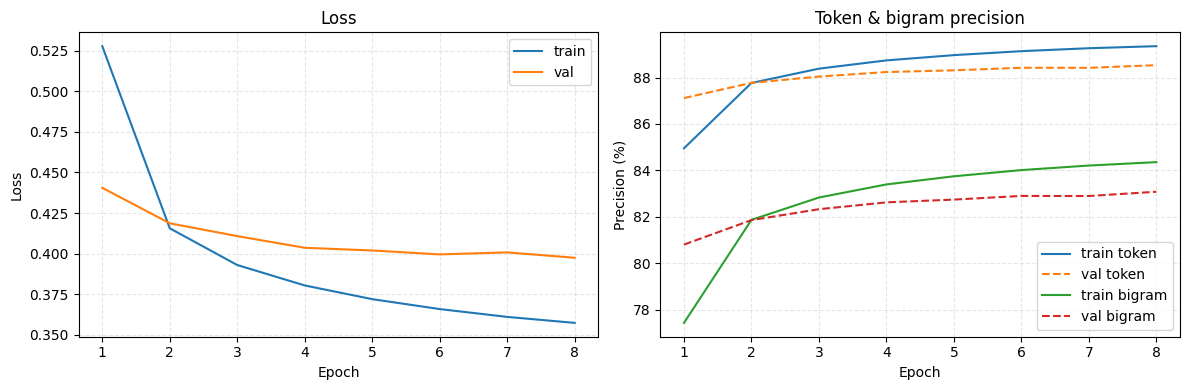

In [52]:
plot_training_progress(history)


Podemos testar o modelo com algumas sentenças básicas


In [82]:
def predict_sentence(model, pinyin_sentence):
    """Convert pinyin sentence to hanzi."""
    tokens = pinyin_sentence.strip().split()
    unk = pinyin_stoi["<unk>"]
    src_ids = [pinyin_stoi.get(tok, unk) for tok in tokens]
    src = torch.tensor(src_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)
    with torch.no_grad():
        candidate_logits, candidate_ids = model(src)
        best_candidate_idx = candidate_logits.argmax(dim=-1)
        pred_hanzi_ids = torch.gather(
            candidate_ids,
            dim=-1,
            index=best_candidate_idx.unsqueeze(-1)
        ).squeeze(-1).squeeze(0).tolist()
    return "".join(hanzi_itos[i] for i in pred_hanzi_ids)

demo_sentences = [
    "ni3 hao3 ma3 ?",
    "wo3 men qu4 you2 yong3 .",
    "ming2 tian1 wo3 men qu4 you2 yong3 , hao3 ma ?",
    "jin1 tian1 de tian1 qi4 zen3 me yang4 ?",
    "wo3 yao4 ka1 fei1 !",
]

for pinyin in demo_sentences:
    hanzi = predict_sentence(model, pinyin)
    print(f"\n{pinyin}")
    print(f"→ {hanzi}")


ni3 hao3 ma3 ?
→ 你好马?

wo3 men qu4 you2 yong3 .
→ 我们去游泳.

ming2 tian1 wo3 men qu4 you2 yong3 , hao3 ma ?
→ 明天我们去游泳,好吗?

jin1 tian1 de tian1 qi4 zen3 me yang4 ?
→ 今天的天气怎么样?

wo3 yao4 ka1 fei1 !
→ 我要咖啡!



Podemos também traduzir uma sentença arbitrária


In [81]:
arb = input()
print(predict_sentence(model, arb))

 ni3 shi4 zhong1 guo2 ren2 , wo3 shi4 ba1 xi1 ren2


你是中国人,我是巴西人
